In [49]:
import warnings
warnings.filterwarnings("ignore")

import ast
import os
import json
import pandas as pd
import torch
import importlib
import cv2 

from shutil import copyfile
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupKFold
from PIL import Image
from string import Template
from IPython.display import display
import os
import ast
import random
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.pyplot import figure
from shapely.geometry import Polygon
import seaborn as sns
from glob import glob
import yaml
import warnings
warnings.filterwarnings("ignore")

from itertools import groupby
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
import glob
from os import listdir
from os.path import isfile, join
from glob import glob
import yaml

import shutil
from shutil import copyfile
import sys

from joblib import Parallel, delayed

TRAIN_PATH = '/media/ken/01D7D016D3925700/kaggle/YOLOX/dataset'

In [2]:
%cd yolov5

/media/ken/01D7D016D3925700/kaggle/prediction/yolov5


In [3]:
REMOVE_NOBBOX = True # remove images with no bbox
IMAGE_SPLIT   = 4 # Image split : (eg : 2, 4...)
WIDTH         = 1280
HEIGHT        = 720

In [4]:
print('All image size will be : ('+str(HEIGHT//IMAGE_SPLIT)+', '+str(WIDTH//IMAGE_SPLIT)+')')

All image size will be : (180, 320)


In [5]:
df = pd.read_csv(TRAIN_PATH+"/train.csv")
df.head(5)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


In [8]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [9]:
# Taken only annotated photos
df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))
df_train = df[df["num_bbox"]>0]

#Annotations 
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)

#Images resolution
df_train["width"] = 1280
df_train["height"] = 720

#Path of images
df_train = df_train.progress_apply(get_path, axis=1)

In [10]:
df_train.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bbox,bboxes,width,height,image_path
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1,"[[559, 213, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1,"[[558, 213, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1,"[[557, 213, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1,"[[556, 214, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1,"[[555, 214, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...


In [11]:
def plot_image_and_bboxes(img, bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.axis('off')
    ax.imshow(img)
    
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor="none")
        ax.add_patch(rect)
    
    plt.show()

In [12]:
def get_image(img_name):
    return np.array(Image.open(img_name))

In [13]:
def image_tiler(img, s_h=180, s_w=320):
    tiles = [img[x:x+s_h,y:y+s_w] for x in range(0,img.shape[0],s_h) for y in range(0,img.shape[1],s_w)]
    return tiles  

In [14]:
def tiler(image_id, bboxes, s_h = 180, s_w = 320, height = 720, width = 1280):
    basename   = image_id

    tiles_dict = {}
    boxes      = []
    
    for bbox in bboxes:
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0] + bbox[2]
        y2 = bbox[1] + bbox[3]
        boxes.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
    for i in range((height // s_h)):
        for j in range((width // s_w)):
            
            x1 = j*s_w
            y1 = height - (i*s_h)
            x2 = ((j+1)*s_w)
            y2 = (height - (i+1)*s_h)
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            
            slice_labels = []
            
            for box in boxes:
                if pol.intersects(box):
                    inter = pol.intersection(box)                        
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    new_width  = (max(x) - min(x))
                    new_height = (max(y) - min(y))
                    
                    # Get new_x min and new_y min
                    new_x = (min(x) - x1)
                    new_y = (min(y) - y2)
                    
                    # Remove small bbox (unsignificant for training)
                    if ((new_width > 14) and (new_height > 14)):
                        slice_labels.append([new_x, new_y, new_width, new_height])
            tiles_dict[basename + "-" + str(IMAGE_SPLIT-i-1)+"-"+str(j)] = slice_labels
    return dict(sorted(tiles_dict.items()))

In [15]:
def keep_bboxes_tiles(tiles, tiles_dict):
    bboxes_tiles = {}
    tiles_keys = [*tiles_dict]
    for k, v in tiles_dict.items():
        if len(v):
            tile_index = tiles_keys.index(k)
            bboxes_tiles[k] = np.array([tiles[tile_index], np.array(v)], dtype=object)
    return bboxes_tiles

In [16]:
df_train.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bbox,bboxes,width,height,image_path
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1,"[[559, 213, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1,"[[558, 213, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1,"[[557, 213, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1,"[[556, 214, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1,"[[555, 214, 50, 32]]",1280,720,/media/ken/01D7D016D3925700/kaggle/YOLOX/datas...


In [17]:
row = df_train.loc[16]

In [18]:
img_name = row.image_id
img  = get_image(row.image_path)
bboxes = row.bboxes

In [19]:
img_name

'0-16'

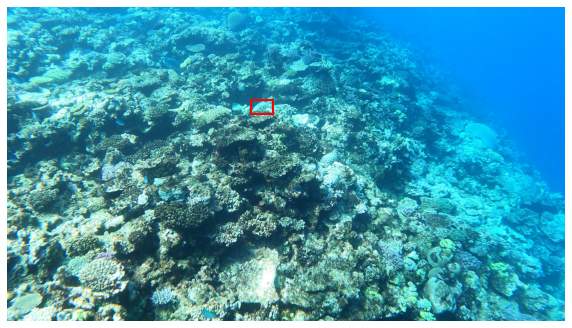

In [20]:
# old_image_path = df_train['image_path'].tolist()
# img_name   = random.choice(old_image_path)

# img        = get_image(img_name)
# bboxes     = df_train.loc[df_train["image_path"] == img_name]["bboxes"].values[0]

plot_image_and_bboxes(img, bboxes)

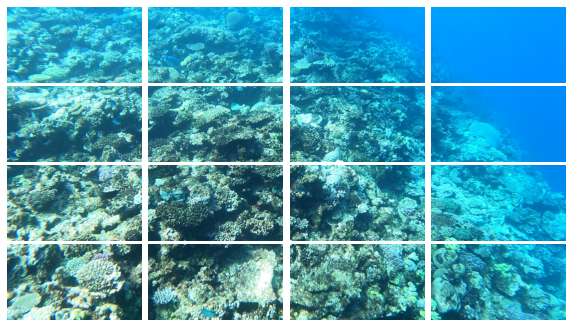

In [21]:
tiles_dict = tiler(img_name, bboxes, s_h = HEIGHT//IMAGE_SPLIT, s_w = WIDTH//IMAGE_SPLIT)
tiles  = image_tiler(img, s_h = HEIGHT//IMAGE_SPLIT, s_w = WIDTH//IMAGE_SPLIT)

_, axs = plt.subplots(IMAGE_SPLIT, IMAGE_SPLIT, figsize=(10, 8))
axs = axs.flatten()
for img, ax in zip(tiles, axs):
    # print(img.shape)
    ax.axis('off')
    ax.imshow(img)
plt.subplots_adjust(wspace=0.05, hspace=-0.6)
plt.show()

In [22]:
# tiler_plot(img_name, bboxes, s_h = 180, s_w = 320, height = 720, width = 1280)

In [23]:
to_save = keep_bboxes_tiles(tiles, tiles_dict)
for k, v in to_save.items():
    print("IMAGE NAME :",k)
    print("NEW BBOXES :",v[1])
    # plot_image_and_bboxes(v[0], v[1])

IMAGE NAME : 0-16-1-1
NEW BBOXES : [[239.  33.  50.  32.]]


In [24]:
df_tilling = pd.DataFrame(columns=df_train.columns)

In [25]:
df_tilling

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bbox,bboxes,width,height,image_path


In [26]:
df_train = df_train.reset_index(drop=True)

In [27]:
for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    
    img_name = row.image_id
    img  = get_image(row.image_path)
    bboxes = row.bboxes
    
    tiles_dict = tiler(img_name, bboxes, s_h = HEIGHT//IMAGE_SPLIT, s_w = WIDTH//IMAGE_SPLIT)
    tiles  = image_tiler(img, s_h = HEIGHT//IMAGE_SPLIT, s_w = WIDTH//IMAGE_SPLIT)

    to_save = keep_bboxes_tiles(tiles, tiles_dict)
    for k, v in to_save.items():
        H,W = (180, 320)
        # print("IMAGE NAME :",k)
        # print("NEW BBOXES :",v[1])
        row.width = W
        row.height = H
        
        row.image_id = k
        row.bboxes = v[1]
        row.image_path = "/media/ken/01D7D016D3925700/kaggle/prediction/image_tilling/"+row.image_id+".jpg"
        cv2.imwrite(row.image_path,v[0])
        df_tilling=df_tilling.append(row)

In [28]:
df_tilling

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bbox,bboxes,width,height,image_path
0,0,40258,16,16,0-16-1-1,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1,"[[239.0, 33.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...
1,0,40258,17,17,0-17-1-1,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1,"[[238.0, 33.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...
2,0,40258,18,18,0-18-1-1,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1,"[[237.0, 33.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...
3,0,40258,19,19,0-19-1-1,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1,"[[236.0, 34.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...
4,0,40258,20,20,0-20-1-1,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1,"[[235.0, 34.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...
...,...,...,...,...,...,...,...,...,...,...,...
4914,2,29859,10628,2856,2-10628-3-0,"[{'x': 92, 'y': 532, 'width': 40, 'height': 37}]",1,"[[92.0, 0.0, 40.0, 29.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...
4915,2,29859,10629,2857,2-10629-3-0,"[{'x': 78, 'y': 569, 'width': 40, 'height': 37}]",1,"[[78.0, 29.0, 40.0, 37.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...
4916,2,29859,10630,2858,2-10630-3-0,"[{'x': 65, 'y': 606, 'width': 41, 'height': 37}]",1,"[[65.0, 66.0, 41.0, 37.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...
4917,2,29859,10631,2859,2-10631-3-0,"[{'x': 51, 'y': 643, 'width': 44, 'height': 37}]",1,"[[51.0, 103.0, 44.0, 37.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...


In [29]:
IMAGE_DIR = 'dataset/2017/images' # directory to save images
LABEL_DIR = 'dataset/2017/labels' # directory to save labels

In [30]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

In [31]:
df_tilling['label_path']  = f'{LABEL_DIR}/'+df_tilling.image_id+'.txt'

In [32]:
df_tilling

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bbox,bboxes,width,height,image_path,label_path
0,0,40258,16,16,0-16-1-1,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1,"[[239.0, 33.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-16-1-1.txt
1,0,40258,17,17,0-17-1-1,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1,"[[238.0, 33.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-17-1-1.txt
2,0,40258,18,18,0-18-1-1,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1,"[[237.0, 33.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-18-1-1.txt
3,0,40258,19,19,0-19-1-1,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1,"[[236.0, 34.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-19-1-1.txt
4,0,40258,20,20,0-20-1-1,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1,"[[235.0, 34.0, 50.0, 32.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-20-1-1.txt
...,...,...,...,...,...,...,...,...,...,...,...,...
4914,2,29859,10628,2856,2-10628-3-0,"[{'x': 92, 'y': 532, 'width': 40, 'height': 37}]",1,"[[92.0, 0.0, 40.0, 29.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/2-10628-3-0.txt
4915,2,29859,10629,2857,2-10629-3-0,"[{'x': 78, 'y': 569, 'width': 40, 'height': 37}]",1,"[[78.0, 29.0, 40.0, 37.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/2-10629-3-0.txt
4916,2,29859,10630,2858,2-10630-3-0,"[{'x': 65, 'y': 606, 'width': 41, 'height': 37}]",1,"[[65.0, 66.0, 41.0, 37.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/2-10630-3-0.txt
4917,2,29859,10631,2859,2-10631-3-0,"[{'x': 51, 'y': 643, 'width': 44, 'height': 37}]",1,"[[51.0, 103.0, 44.0, 37.0]]",320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/2-10631-3-0.txt


In [38]:
def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes
def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [0, 0, 255], thickness=tf, lineType=cv2.LINE_AA)



def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

np.random.seed(8)
colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
colors=(255,0,0)

In [39]:
kf = GroupKFold(n_splits = 5) 
df_tilling = df_tilling.reset_index(drop=True)
df_tilling['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_tilling, y = df_tilling.video_id.tolist(), groups=df_tilling.sequence)):
    df_tilling.loc[val_idx, 'fold'] = fold

df_tilling.head(5)

,video_id,sequence,video_frame,sequence_frame,image_id,...,width,height,image_path,label_path,fold
0,0,40258,16,16,0-16-1-1,...,320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-16-1-1.txt,4
1,0,40258,17,17,0-17-1-1,...,320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-17-1-1.txt,4
2,0,40258,18,18,0-18-1-1,...,320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-18-1-1.txt,4
3,0,40258,19,19,0-19-1-1,...,320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-19-1-1.txt,4
4,0,40258,20,20,0-20-1-1,...,320,180,/media/ken/01D7D016D3925700/kaggle/prediction/...,dataset/2017/labels/0-20-1-1.txt,4


In [40]:
display(df_tilling.fold.value_counts())

0    2587
1    1875
4    1849
3    1847
2    1845
Name: fold, dtype: int64

In [41]:
os.makedirs('COTS/images/train', exist_ok=True)
os.makedirs('COTS/images/valid', exist_ok=True)
os.makedirs('COTS/labels/train', exist_ok=True)
os.makedirs('COTS/labels/valid', exist_ok=True)

In [42]:
Selected_Fold=4  #0..4

In [43]:
for i in tqdm(range(len(df_tilling))):
    row = df_tilling.loc[i]
    if row.fold != Selected_Fold:
        copyfile(f'{row.image_path}', f'COTS/images/train/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'COTS/images/valid/{row.image_id}.jpg') 

In [44]:
list1 = os.listdir('COTS/images/train') # dir is your directory path
number_files1 = len(list1)
print("Number of images in ./COTS/images/train folder",number_files1)
list2 = os.listdir('COTS/images/valid') # dir is your directory path
number_files2 = len(list2)
print("Number of images in ./COTS/images/valid folder",number_files2)

Number of images in ./COTS/images/train folder 8154
Number of images in ./COTS/images/valid folder 1849


In [47]:
import yaml
with open('train.txt', 'w') as f:
    for path in glob('COTS/images/train/*'):
        f.write(path+'\n')
            
with open('val.txt', 'w') as f:
    for path in glob('COTS/images/valid/*'):
        f.write(path+'\n')

data = dict(
    train = 'COTS/images/train',
    val = 'COTS/images/valid',
    
    nc    = 1, # number of classes
    names =  ['cots'] # classes
    )

with open('data/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

%cat data/data.yaml

names:
- cots
nc: 1
train: COTS/images/train
val: COTS/images/valid


In [56]:
all_bboxes = []
for i in tqdm(range(len(df_tilling))):
    row = df_tilling.loc[i]
    # Get image
    image_name = row.image_id
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = [0]*num_bbox
    if row.fold != Selected_Fold:
        file_name = f'COTS/labels/train/{image_name}.txt'
    else:
        file_name = f'COTS/labels/valid/{image_name}.txt'

    with open(file_name, 'w') as f:
        bboxes_yolo  = coco2yolo(image_height, image_width, bboxes_coco)
        bboxes_yolo  = np.clip(bboxes_yolo, 0, 1)
        all_bboxes.extend(bboxes_yolo)
        for bbox_idx in range(len(bboxes_yolo)):
            bb=str(bboxes_yolo[bbox_idx])
            bb=bb[1:-1]
            #annot = [str(labels[bbox_idx])]+ list(bboxes_yolo[bbox_idx].astype(str))+(['\n'] if num_bbox!=(bbox_idx+1) else [''])
            annot = str(str(labels[bbox_idx])) + ' ' + bb + '\n'
            annot = ''.join(annot)
            annot = annot.strip('')
            f.write(annot)

In [57]:
list1 = os.listdir('COTS/labels/train') # dir is your directory path
number_files1 = len(list1)
print("Number of txt file in ./COTS/labels/train folder",number_files1)
list2 = os.listdir('COTS/labels/valid') # dir is your directory path
number_files2 = len(list2)
print("Number of txt file in ./COTS/labels/valid folder",number_files2)

Number of txt file in ./COTS/labels/train folder 8154
Number of txt file in ./COTS/labels/valid folder 1849


In [ ]:
%cat '/kaggle/working/COTS/labels/train/{list1[10]}'